In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

# Dataset Preparation

'Building_energy_index', 'Building_bag_residence_object_id', 'Building_usable_floor_area_thermal_zone', 'Building_energy_requirement',
                      'Building_primary_fossil_energy', 'Building_primary_fossil_energy_EMG_standard', 'Building_share_renewable_energy', 
                      'Building_temperature_exceedance', 'Building_heat_demand', 'Building_energy_index_with_EMG_standard'

In [2]:
DATA_PATH = '../data/out/dataset_v202441617541'
data = pd.read_csv(DATA_PATH)
data

,Unnamed: 0,Building_bag_building_id,Building_type,Building_subtype,Building_postcode_num,Building_energy_class,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,id,year,volume,floors,roof_type,greenhouse,geographicalExtent
0,0,3.631000e+14,NaN,NaN,1011,C,112.11,0.0,220.06,132.74,1735.09,NL.IMBAG.Pand.0363100012181958,1948.0,6891.854004,NaN,multiple horizontal,False,"[122184.046875, 487858.3125, 1.467000007629394..."
1,1,3.631000e+14,Appartement,Tussenmidden,1011,A++,44.16,54.0,55.98,73.75,145.08,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
2,2,3.631000e+14,Appartement,Tussenmidden,1011,A++,46.42,55.4,56.83,78.20,145.08,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
3,3,3.631000e+14,Appartement,Tussenmidden,1011,A++,47.03,54.8,56.88,77.05,145.08,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
4,4,3.631000e+14,Appartement,Tussendak,1011,A+++,68.95,81.0,28.53,110.55,292.63,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104502,104502,3.841000e+14,Appartement,Tussendak,1112,A,90.01,24.6,72.11,116.73,122.14,NL.IMBAG.Pand.0384100000011622,2021.0,55637.558594,NaN,multiple horizontal,False,"[125828.09375, 482246.75, -2.979997396469116, ..."
104503,104503,3.841000e+14,Appartement,Hoekmidden,1112,A+,61.17,26.3,53.90,78.92,117.90,NL.IMBAG.Pand.0384100000011622,2021.0,55637.558594,NaN,multiple horizontal,False,"[125828.09375, 482246.75, -2.979997396469116, ..."
104504,104504,3.841000e+14,Appartement,Hoekdak,1112,A,105.15,23.8,85.46,128.50,118.20,NL.IMBAG.Pand.0384100000011622,2021.0,55637.558594,NaN,multiple horizontal,False,"[125828.09375, 482246.75, -2.979997396469116, ..."
104505,104505,3.841000e+14,Appartement,Tussenmidden,1112,A+,60.11,0.0,69.90,61.55,59.00,NL.IMBAG.Pand.0384100000011455,2020.0,44805.992188,NaN,multiple horizontal,False,"[125947.5234375, 482448.3125, -1.7599999904632..."


In [3]:
data['Building_type'].unique()

array([nan, 'Appartement', 'Rijwoning hoek', 'Rijwoning tussen',
       'Vrijstaande woning',
       'Woongebouw met niet-zelfstandige woonruimte',
       'Twee-onder-één-kap', 'Logieswoning'], dtype=object)

### Removing outliers

In [4]:
data = data[data['Building_heat_demand'] < 1000]
data = data[data['Building_primary_fossil_energy'] < 1e4]
data = data[data['volume'] > 0]
data = data.dropna(subset=['Building_type'])
data

,Unnamed: 0,Building_bag_building_id,Building_type,Building_subtype,Building_postcode_num,Building_energy_class,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,id,year,volume,floors,roof_type,greenhouse,geographicalExtent
1,1,3.631000e+14,Appartement,Tussenmidden,1011,A++,44.16,54.0,55.98,73.75,145.08,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
2,2,3.631000e+14,Appartement,Tussenmidden,1011,A++,46.42,55.4,56.83,78.20,145.08,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
3,3,3.631000e+14,Appartement,Tussenmidden,1011,A++,47.03,54.8,56.88,77.05,145.08,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
4,4,3.631000e+14,Appartement,Tussendak,1011,A+++,68.95,81.0,28.53,110.55,292.63,NL.IMBAG.Pand.0363100012181959,1916.0,2149.765625,NaN,slanted,False,"[122198.2265625, 487857.5, 1.3890000581741333,..."
7,7,3.631000e+14,Appartement,Tussenmidden,1011,E,225.00,0.0,316.75,231.23,63.37,NL.IMBAG.Pand.0363100012171918,1600.0,458.810638,5.0,slanted,False,"[122015.3984375, 487643.28125, 2.5009999275207..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104502,104502,3.841000e+14,Appartement,Tussendak,1112,A,90.01,24.6,72.11,116.73,122.14,NL.IMBAG.Pand.0384100000011622,2021.0,55637.558594,NaN,multiple horizontal,False,"[125828.09375, 482246.75, -2.979997396469116, ..."
104503,104503,3.841000e+14,Appartement,Hoekmidden,1112,A+,61.17,26.3,53.90,78.92,117.90,NL.IMBAG.Pand.0384100000011622,2021.0,55637.558594,NaN,multiple horizontal,False,"[125828.09375, 482246.75, -2.979997396469116, ..."
104504,104504,3.841000e+14,Appartement,Hoekdak,1112,A,105.15,23.8,85.46,128.50,118.20,NL.IMBAG.Pand.0384100000011622,2021.0,55637.558594,NaN,multiple horizontal,False,"[125828.09375, 482246.75, -2.979997396469116, ..."
104505,104505,3.841000e+14,Appartement,Tussenmidden,1112,A+,60.11,0.0,69.90,61.55,59.00,NL.IMBAG.Pand.0384100000011455,2020.0,44805.992188,NaN,multiple horizontal,False,"[125947.5234375, 482448.3125, -1.7599999904632..."


In [5]:
building_types = data.groupby('Building_type')[['Building_heat_demand',
       'Building_share_renewable_energy', 'Building_primary_fossil_energy',
       'Building_energy_requirement',
       'Building_usable_floor_area_thermal_zone', 'volume', 'year']].describe()
building_types

Building_heat_demand              \
                                                           count        mean   
Building_type                                                                  
Appartement                                              75022.0  119.955910   
Logieswoning                                                31.0  108.183548   
Rijwoning hoek                                            2024.0  149.761151   
Rijwoning tussen                                          6113.0  118.464243   
Twee-onder-één-kap                                         270.0  170.695889   
Vrijstaande woning                                         239.0  170.905649   
Woongebouw met niet-zelfstandige woonruimte                378.0  117.305450   

                                                                         \
                                                   std    min       25%   
Building_type                                                             
Appartement                                  64.299684   7.00   73.2025   
Logieswoning                                  6.062804  99.33  106.0150   
Rijwoning hoek                               59.857962  34.47  106.0000   
Rijwoning tussen                             45.623046  26.00   88.3500   
Twee-onder-één-kap                           66.190764  58.54  109.2775   
Vrijstaande woning                           82.833400  39.03  102.6200   
Woongebouw met niet-zelfstandige woonruimte  52.440375  58.00   76.0000   

                                                                      \
                                                 50%     75%     max   
Building_type                                                          
Appartement                                  106.200  155.00  838.00   
Logieswoning                                 106.400  113.11  120.14   
Rijwoning hoek                               128.310  182.70  408.00   
Rijwoning tussen                             103.000  143.00  583.00   
Twee-onder-één-kap                           162.485  231.89  384.33   
Vrijstaande woning                           156.990  208.48  505.00   
Woongebouw met niet-zelfstandige woonruimte  110.530  138.00  486.00   

                                            Building_share_renewable_energy  \
                                                                      count   
Building_type                                                                 
Appartement                                                         75022.0   
Logieswoning                                                           31.0   
Rijwoning hoek                                                       2024.0   
Rijwoning tussen                                                     6113.0   
Twee-onder-één-kap                                                    270.0   
Vrijstaande woning                                                    239.0   
Woongebouw met niet-zelfstandige woonruimte                           378.0   

                                                        ...        volume  \
                                                  mean  ...           75%   
Building_type                                           ...                 
Appartement                                  11.832524  ...  17530.597656   
Logieswoning                                 20.322581  ...    444.888626   
Rijwoning hoek                                6.495603  ...    437.257195   
Rijwoning tussen                              9.011042  ...    426.550323   
Twee-onder-één-kap                            6.190370  ...    576.661362   
Vrijstaande woning                           12.874895  ...    934.141724   
Woongebouw met niet-zelfstandige woonruimte   0.523280  ...   9972.349609   

                                                               year  \
                                                       max    count   
Building_type                                                      

In [6]:
df = data.dropna()

In [7]:
energy_label_num = {'A+++++': 1, 'A++++': 2, 'A+++': 3, 'A++': 4, 'A+': 5, 'A': 6, 'B': 7, 'C': 8, 'D': 9, 'E': 10, 'F': 11, 'G': 12}

In [8]:
#Create new label numerical column to make average label
df['energy_label_num'] = df['Building_energy_class'].apply(lambda label: energy_label_num[label])

/var/folders/tt/59b1f78918g9z5zhcmxxssqm0000gn/T/ipykernel_73964/1141454066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['energy_label_num'] = df['Building_energy_class'].apply(lambda label: energy_label_num[label])


In [9]:
df = df.groupby('Building_bag_building_id').agg({
    'Building_bag_building_id': 'max',
    'energy_label_num': 'mean',  
    'Building_heat_demand': 'mean',
    'Building_share_renewable_energy': 'max',
    'Building_primary_fossil_energy': 'mean',
    'Building_energy_requirement': 'mean',
    'volume': 'mean',
    'year': 'mean',
    'volume': 'mean',
    'Building_usable_floor_area_thermal_zone': 'mean',
    'geographicalExtent': 'first'
})[['Building_bag_building_id','energy_label_num', 'Building_heat_demand', 'Building_share_renewable_energy', 'Building_primary_fossil_energy', 
   'Building_energy_requirement', 'Building_usable_floor_area_thermal_zone', 'year', 'volume', 'geographicalExtent']]
df

,Building_bag_building_id,energy_label_num,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,year,volume,geographicalExtent
Building_bag_building_id,,,,,,,,,,
3.631000e+14,3.631000e+14,9.750000,217.637500,0.0,297.252500,212.870000,73.842500,1956.0,1234.743042,"[118594.78125, 485656.71875, 0.537000000476837..."
3.631000e+14,3.631000e+14,8.500000,163.830000,0.0,230.815000,151.625000,79.325000,1923.0,621.632812,"[121578.9375, 484494.25, 0.44999998807907104, ..."
3.631000e+14,3.631000e+14,6.000000,83.320000,71.7,39.590000,85.865000,110.520000,1998.0,817.388794,"[113561.2421875, 484893.53125, -2.628000020980..."
3.631000e+14,3.631000e+14,8.000000,169.750000,0.0,247.270000,169.010000,95.870000,1931.0,1129.644897,"[118461.7109375, 485004.21875, 0.3400000035762..."
3.631000e+14,3.631000e+14,12.000000,286.000000,0.0,385.990000,284.390000,55.500000,1928.0,975.639648,"[118372.265625, 484806.78125, 0.45600000023841..."
...,...,...,...,...,...,...,...,...,...,...
3.841000e+14,3.841000e+14,5.500000,86.940000,43.4,119.250000,88.385000,72.800000,1990.0,447.679077,"[126760.3359375, 484903.1875, -0.7810000181198..."
3.841000e+14,3.841000e+14,6.000000,96.590000,44.5,128.125000,99.890000,72.800000,1990.0,532.435669,"[126765.0703125, 484904.5, -0.9390000104904175..."
3.841000e+14,3.841000e+14,5.500000,62.745000,19.0,95.790000,69.355000,88.440000,2017.0,5978.157227,"[126954.3046875, 483367.78125, -1.072999954223..."


In [10]:
#Convert the energy_label_num back to categorical value
num_to_energy_label = {v: k for k, v in energy_label_num.items()}
num_to_energy_label

{1: 'A+++++',
 2: 'A++++',
 3: 'A+++',
 4: 'A++',
 5: 'A+',
 6: 'A',
 7: 'B',
 8: 'C',
 9: 'D',
 10: 'E',
 11: 'F',
 12: 'G'}

In [11]:
df['energy_label'] = df['energy_label_num'].apply(lambda label: num_to_energy_label[round(label)])
df

,Building_bag_building_id,energy_label_num,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,year,volume,geographicalExtent,energy_label
Building_bag_building_id,,,,,,,,,,,
3.631000e+14,3.631000e+14,9.750000,217.637500,0.0,297.252500,212.870000,73.842500,1956.0,1234.743042,"[118594.78125, 485656.71875, 0.537000000476837...",E
3.631000e+14,3.631000e+14,8.500000,163.830000,0.0,230.815000,151.625000,79.325000,1923.0,621.632812,"[121578.9375, 484494.25, 0.44999998807907104, ...",C
3.631000e+14,3.631000e+14,6.000000,83.320000,71.7,39.590000,85.865000,110.520000,1998.0,817.388794,"[113561.2421875, 484893.53125, -2.628000020980...",A
3.631000e+14,3.631000e+14,8.000000,169.750000,0.0,247.270000,169.010000,95.870000,1931.0,1129.644897,"[118461.7109375, 485004.21875, 0.3400000035762...",C
3.631000e+14,3.631000e+14,12.000000,286.000000,0.0,385.990000,284.390000,55.500000,1928.0,975.639648,"[118372.265625, 484806.78125, 0.45600000023841...",G
...,...,...,...,...,...,...,...,...,...,...,...
3.841000e+14,3.841000e+14,5.500000,86.940000,43.4,119.250000,88.385000,72.800000,1990.0,447.679077,"[126760.3359375, 484903.1875, -0.7810000181198...",A
3.841000e+14,3.841000e+14,6.000000,96.590000,44.5,128.125000,99.890000,72.800000,1990.0,532.435669,"[126765.0703125, 484904.5, -0.9390000104904175...",A
3.841000e+14,3.841000e+14,5.500000,62.745000,19.0,95.790000,69.355000,88.440000,2017.0,5978.157227,"[126954.3046875, 483367.78125, -1.072999954223...",A


# Kmean

In [12]:
df.dtypes

Building_bag_building_id                   float64
energy_label_num                           float64
Building_heat_demand                       float64
Building_share_renewable_energy            float64
Building_primary_fossil_energy             float64
Building_energy_requirement                float64
Building_usable_floor_area_thermal_zone    float64
year                                       float64
volume                                     float64
geographicalExtent                          object
energy_label                                object
dtype: object

In [13]:
df.columns

Index(['Building_bag_building_id', 'energy_label_num', 'Building_heat_demand',
       'Building_share_renewable_energy', 'Building_primary_fossil_energy',
       'Building_energy_requirement',
       'Building_usable_floor_area_thermal_zone', 'year', 'volume',
       'geographicalExtent', 'energy_label'],
      dtype='object')

In [14]:
# Define numerical and categorical features
numerical_features = ['Building_heat_demand', 'volume','Building_primary_fossil_energy', 'Building_energy_requirement','Building_usable_floor_area_thermal_zone'
       ,'Building_energy_requirement', 'year']
''','Building_primary_fossil_energy', 'Building_energy_requirement','Building_usable_floor_area_thermal_zone'
       ,'Building_energy_requirement'
       , 'volume','year' ]''' #'Building_share_renewable_energy'
categorical_features = ['energy_label']
# Convert categorical columns to category dtype
for col in categorical_features:
    df[col] = df[col].astype('category')

In [15]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
#categorical_transformer = OneHotEncoder()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ])

# Apply preprocessing
df_processed = preprocessor.fit_transform(df)

# Convert processed data to a DataFrame (Optional, for PCA and visualization)
df_processed = pd.DataFrame(df_processed)
df_processed

,0,1,2,3,4,5,6
0,1.175977,-0.233418,0.696219,1.241976,0.063266,1.241976,0.635449
1,0.240692,-0.444758,0.001691,0.088722,0.242153,0.088722,-0.070612
2,-1.158737,-0.377281,-1.997348,-1.149549,1.260006,-1.149549,1.534071
3,0.343594,-0.269646,0.173709,0.416085,0.781995,0.416085,0.100554
4,2.364258,-0.322731,1.623869,2.588710,-0.535226,2.588710,0.036367
...,...,...,...,...,...,...,...
21225,-1.095814,-0.504720,-1.164593,-1.102097,0.029251,-1.102097,1.362905
21226,-0.928078,-0.475504,-1.071815,-0.885456,0.029251,-0.885456,1.362905
21227,-1.516373,1.401638,-1.409841,-1.460436,0.539564,-1.460436,1.940591
21228,-1.680137,10.086364,-1.914297,-1.383464,-0.036386,-1.383464,2.026174


In [16]:
df_processed.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
dtype: object

#Cluster: 2
#Cluster: 3
#Cluster: 4
#Cluster: 5
#Cluster: 6
#Cluster: 7
#Cluster: 8
#Cluster: 9
#Cluster: 10


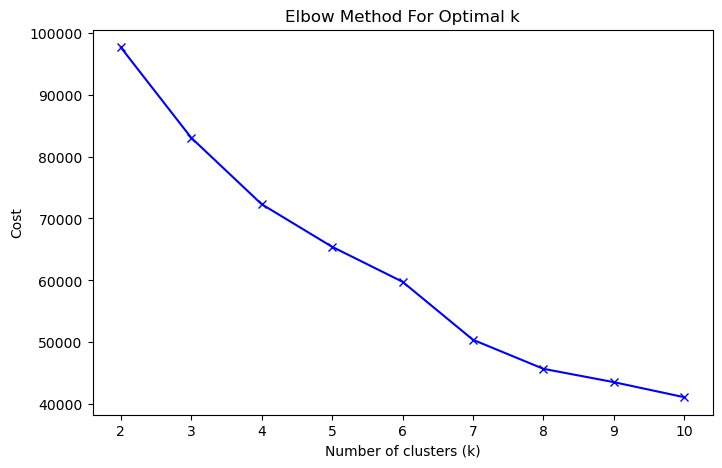

In [17]:

costs = []
K = range(2, 11)
n_init=1

for k in K:
    print(f'#Cluster: {k}')
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=n_init)
    kmeans.fit(df_processed)
    costs.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, costs, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
from yellowbrick.cluster import KElbowVisualizer


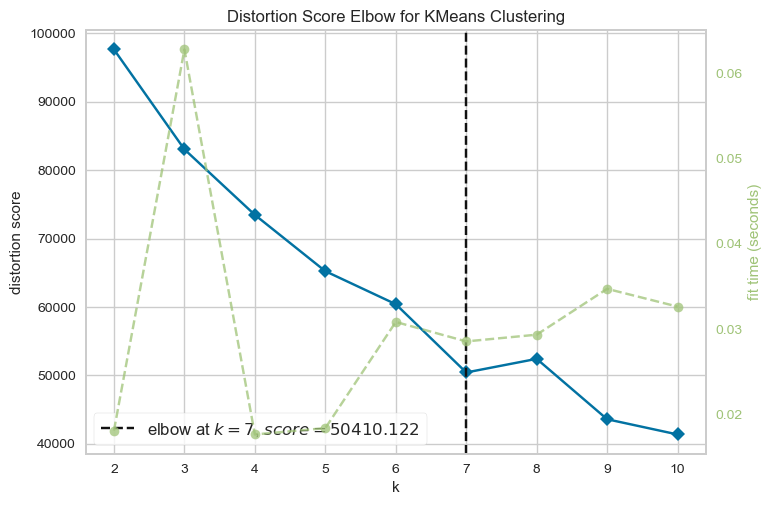

In [19]:
fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(n_init=n_init), k=K,ax=ax)
visualizer.fit(df_processed)

ax.set_xticks(K)
visualizer.show()
plt.show()

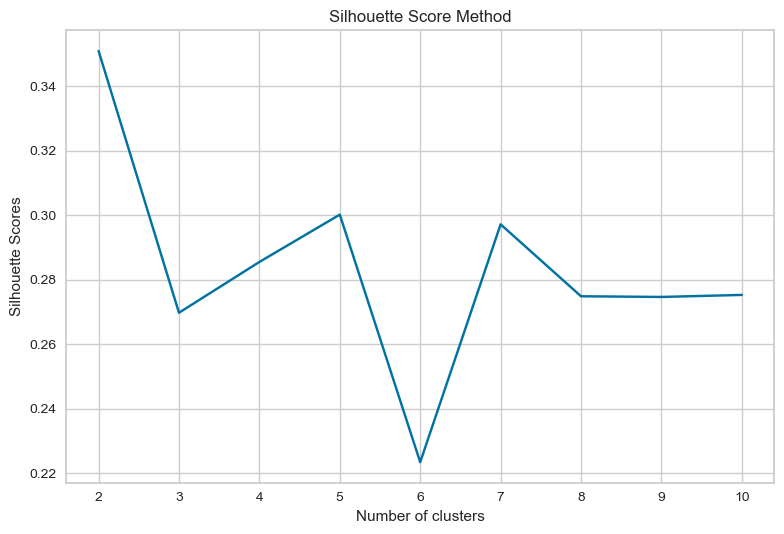

In [20]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in K:
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=1, 
                random_state=42)
    km.fit(df_processed)
    silhouette_scores.append(silhouette_score(df_processed, km.labels_))

fig, ax = plt.subplots()
ax.plot(K, silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(K)
plt.tight_layout()
plt.show()

## Assign Clusters

In [60]:
from kmodes.kprototypes import KPrototypes

# Assuming df_processed is your preprocessed DataFrame and the optimal number of clusters is 3
optimal_k = 4  # Replace with the optimal number of clusters you've determined from the elbow method

# Create an instance of KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=1)

# Fit the model and predict the clusters
cluster_assignment = kmeans.fit_predict(df_processed)


In [61]:
# Assign the cluster labels to your original DataFrame
df['Cluster'] = cluster_assignment

## Modify coordinates

In [62]:
import ast
from pyproj import Transformer

# Define a transformer from EPSG:7415 to EPSG:4326 (WGS84)
transformer = Transformer.from_crs("epsg:7415", "epsg:4326", always_xy=True)

df['coordinates'] = df['geographicalExtent'].apply(lambda lat_long: transformer.transform(ast.literal_eval(lat_long)[0], ast.literal_eval(lat_long)[1]))
df['latitude'] = df['coordinates'].apply(lambda coord: coord[1])
df['longitude'] = df['coordinates'].apply(lambda coord: coord[0])
df['longitude']

Building_bag_building_id
3.631000e+14    4.852801
3.631000e+14    4.896720
3.631000e+14    4.779010
3.631000e+14    4.850919
3.631000e+14    4.849627
                  ...   
3.841000e+14    4.972725
3.841000e+14    4.972795
3.841000e+14    4.975700
3.841000e+14    4.970079
3.841000e+14    4.967564
Name: longitude, Length: 21230, dtype: float64

In [63]:
df['coordinates'].iloc[0][0]

4.852800978413946

## Visualisation

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

/var/folders/tt/59b1f78918g9z5zhcmxxssqm0000gn/T/ipykernel_73964/2443099995.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


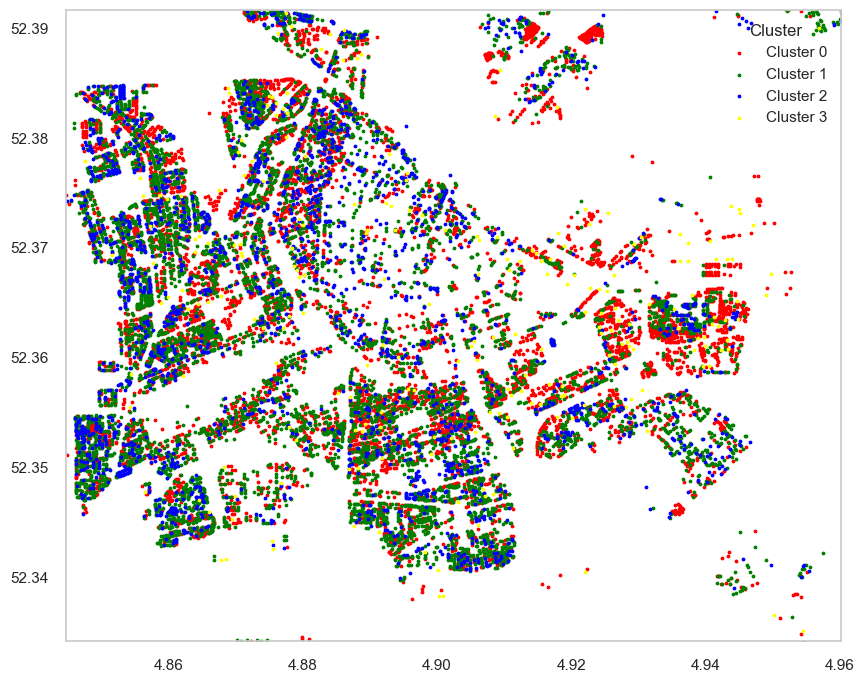

In [65]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # Coordinate Reference System: WGS84
)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
# Focus on Amsterdam area
amsterdam_bounds = {
    'x_min': 4.85,  # min longitude
    'x_max': 4.95,  # max longitude
    'y_min': 52.35,  # min latitude
    'y_max': 52.40   # max latitude
}
# Define colors for each cluster
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'magenta', 'orange', 'cyan']#['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']#
ax.set_xlim(4.84472, 4.96028)
ax.set_ylim(52.33417, 52.39167)
# Plot each cluster with different color
for cluster, group in gdf.groupby('Cluster'):
    color = colors[cluster]
    group.plot(ax=ax, marker='o', markersize=3, label=f'Cluster {cluster}', color=color)

plt.legend(title='Cluster')
#Save in output directory
output_directory = '../data/plots_3/' + str(optimal_k)

if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it does not exist
plt.savefig(output_directory + f'/amsterdam_{optimal_k}_kmean_ninit_{n_init}.png')
plt.show()

In [66]:
df.columns

Index(['Building_bag_building_id', 'energy_label_num', 'Building_heat_demand',
       'Building_share_renewable_energy', 'Building_primary_fossil_energy',
       'Building_energy_requirement',
       'Building_usable_floor_area_thermal_zone', 'year', 'volume',
       'geographicalExtent', 'energy_label', 'Cluster', 'coordinates',
       'latitude', 'longitude'],
      dtype='object')

## Results Analysis

In [67]:
results = df.groupby('Cluster')[['energy_label_num', 'Building_heat_demand',
       'Building_share_renewable_energy', 'Building_primary_fossil_energy',
       'Building_energy_requirement',
       'Building_usable_floor_area_thermal_zone', 'year', 'volume',
       'latitude', 'longitude']].describe()
results

energy_label_num                                                   \
                   count       mean       std  min   25%        50%   75%   
Cluster                                                                     
0                 9106.0   6.711195  0.886485  2.0   6.0   7.000000   7.0   
1                 8775.0   8.646199  0.818213  5.0   8.0   8.500000   9.0   
2                 2974.0  10.800050  0.876465  4.0  10.0  11.000000  12.0   
3                  375.0   6.826591  1.353028  3.0   6.0   6.666667   7.9   

               Building_heat_demand              ...   latitude             \
           max                count        mean  ...        75%        max   
Cluster                                          ...                         
0        12.00               9106.0  101.720978  ...  52.374326  52.422672   
1        12.00               8775.0  167.685579  ...  52.374954  52.419446   
2        12.00               2974.0  251.466695  ...  52.376893  52.419448   
3        11.25                375.0  102.830878  ...  52.373420  52.419905   

        longitude                                                              \
            count      mean       std       min       25%       50%       75%   
Cluster                                                                         
0          9106.0  4.891949  0.040458  4.770899  4.865121  4.889004  4.920450   
1          8775.0  4.881830  0.030753  4.780850  4.859253  4.878461  4.902097   
2          2974.0  4.876708  0.031704  4.781051  4.854196  4.875485  4.898088   
3           375.0  4.898460  0.046593  4.780171  4.872280  4.897351  4.929061   

                   
              max  
Cluster            
0        5.018567  
1        5.018560  
2        5.015549  
3        5.002127  

[4 rows x 80 columns]

In [68]:
df

,Building_bag_building_id,energy_label_num,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,year,volume,geographicalExtent,energy_label,Cluster,coordinates,latitude,longitude
Building_bag_building_id,,,,,,,,,,,,,,,
3.631000e+14,3.631000e+14,9.750000,217.637500,0.0,297.252500,212.870000,73.842500,1956.0,1234.743042,"[118594.78125, 485656.71875, 0.537000000476837...",E,2,"(4.852800978413946, 52.35759961551032)",52.357600,4.852801
3.631000e+14,3.631000e+14,8.500000,163.830000,0.0,230.815000,151.625000,79.325000,1923.0,621.632812,"[121578.9375, 484494.25, 0.44999998807907104, ...",C,1,"(4.896720178613905, 52.34734176852595)",52.347342,4.896720
3.631000e+14,3.631000e+14,6.000000,83.320000,71.7,39.590000,85.865000,110.520000,1998.0,817.388794,"[113561.2421875, 484893.53125, -2.628000020980...",A,0,"(4.779009883443999, 52.3503840852818)",52.350384,4.779010
3.631000e+14,3.631000e+14,8.000000,169.750000,0.0,247.270000,169.010000,95.870000,1931.0,1129.644897,"[118461.7109375, 485004.21875, 0.3400000035762...",C,1,"(4.850918549844552, 52.35172658409516)",52.351727,4.850919
3.631000e+14,3.631000e+14,12.000000,286.000000,0.0,385.990000,284.390000,55.500000,1928.0,975.639648,"[118372.265625, 484806.78125, 0.45600000023841...",G,2,"(4.8496272762217965, 52.349946202652646)",52.349946,4.849627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.841000e+14,3.841000e+14,5.500000,86.940000,43.4,119.250000,88.385000,72.800000,1990.0,447.679077,"[126760.3359375, 484903.1875, -0.7810000181198...",A,0,"(4.9727254475034375, 52.35130773499551)",52.351308,4.972725
3.841000e+14,3.841000e+14,6.000000,96.590000,44.5,128.125000,99.890000,72.800000,1990.0,532.435669,"[126765.0703125, 484904.5, -0.9390000104904175...",A,0,"(4.972794822933009, 52.35131977424991)",52.351320,4.972795
3.841000e+14,3.841000e+14,5.500000,62.745000,19.0,95.790000,69.355000,88.440000,2017.0,5978.157227,"[126954.3046875, 483367.78125, -1.072999954223...",A,0,"(4.9757002151088265, 52.3375183199416)",52.337518,4.975700


### Swarm Plots

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


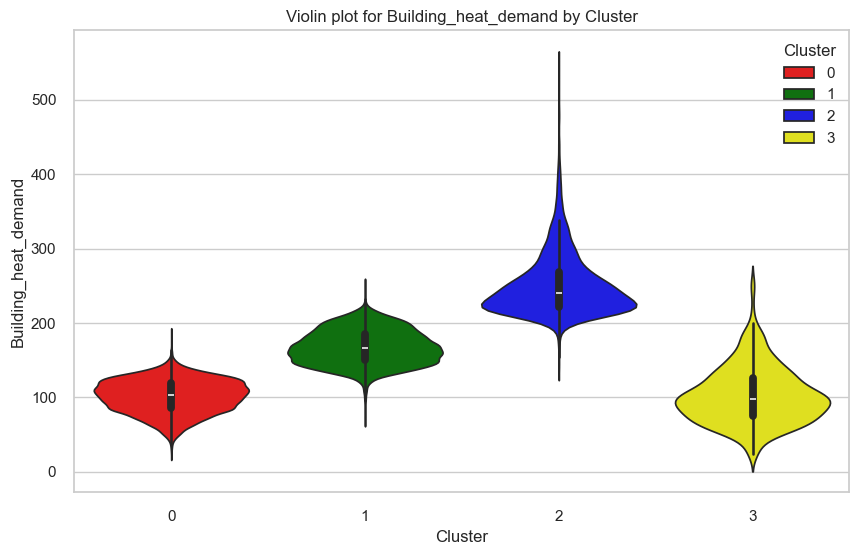

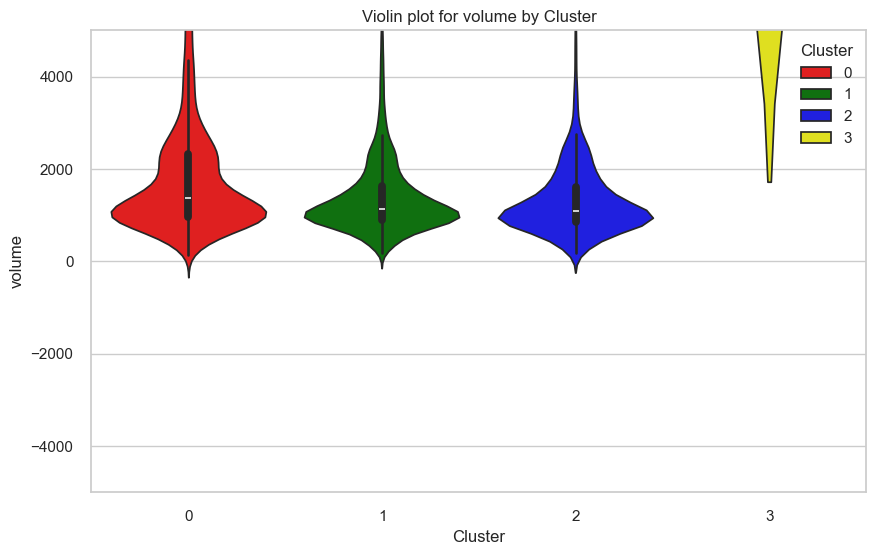

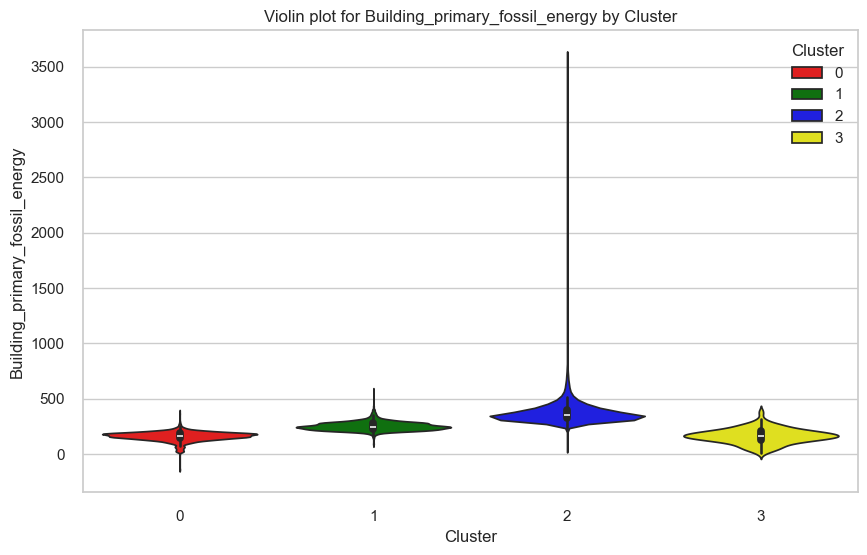

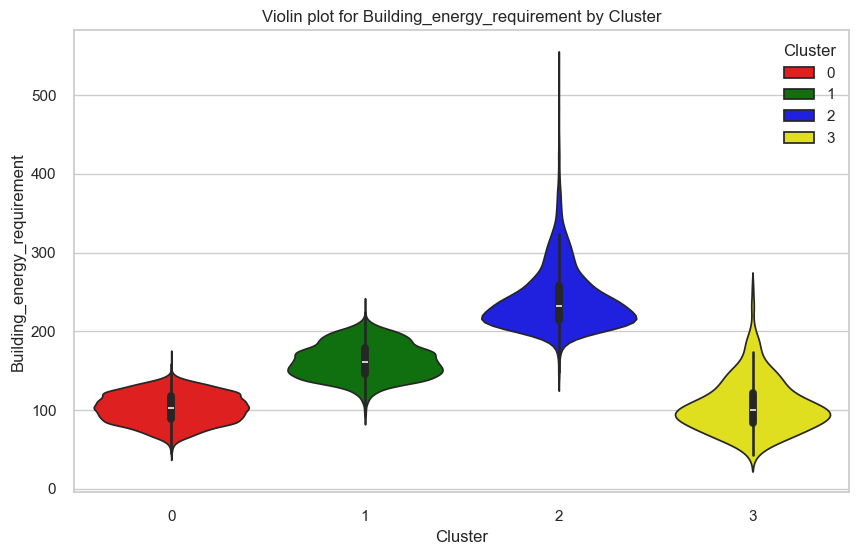

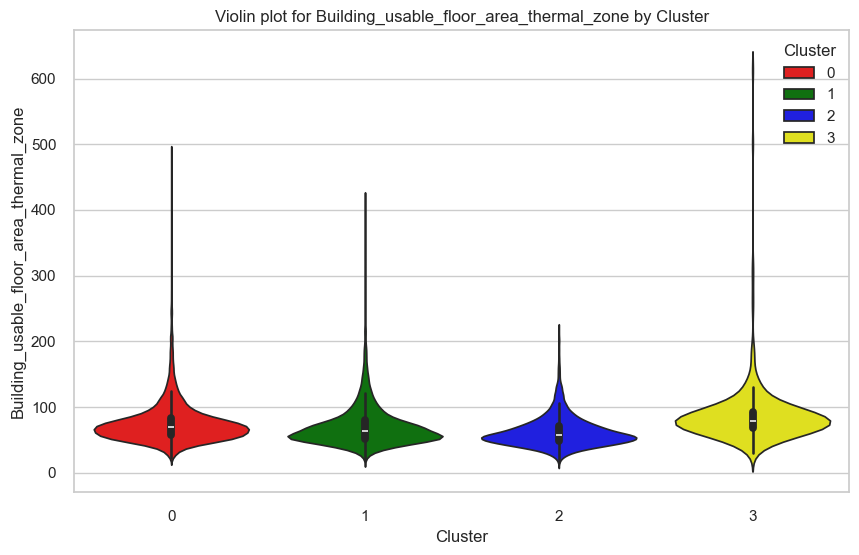

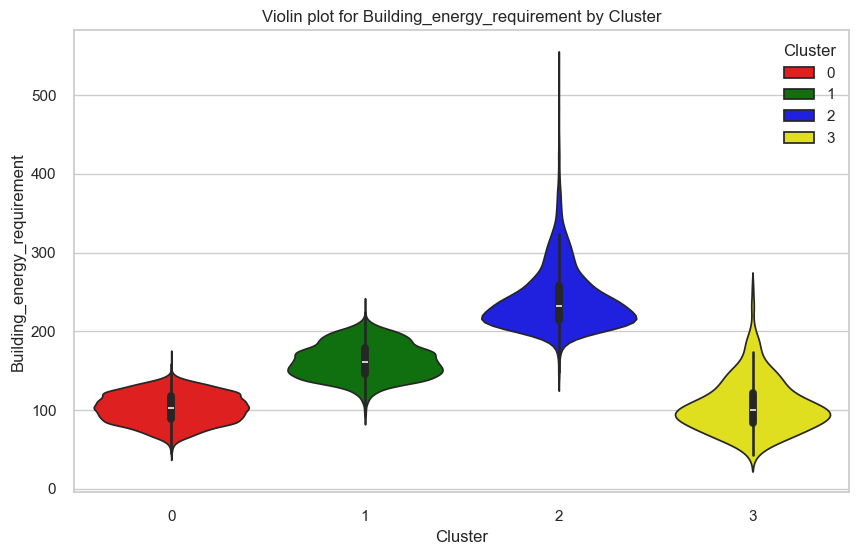

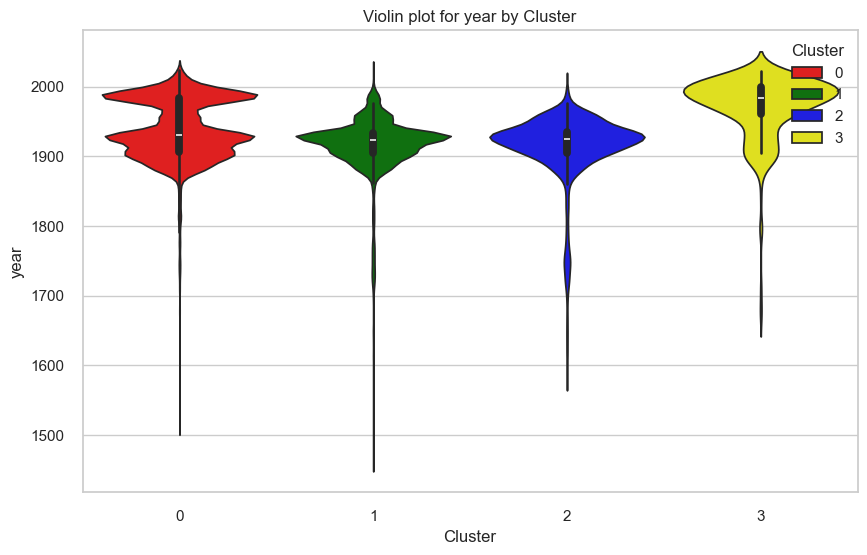

categorcal column


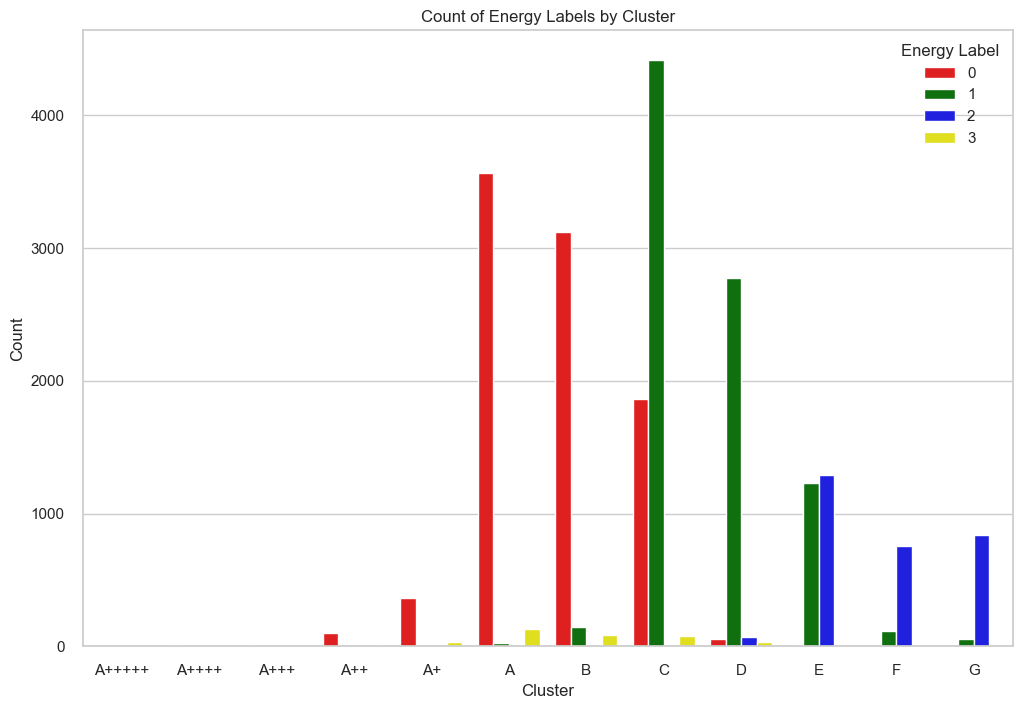

In [70]:

# Assuming you have loaded your DataFrame as `df`
sampled_df = df
# Setting the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Creating a list of numerical and categorical columns
numerical_columns = numerical_features
categorical_columns = categorical_features

# Define colors for each cluster, consistent with the previous geographical plot
num_clusters = sampled_df['Cluster'].nunique()
palette = {i: colors[i % len(colors)] for i in range(num_clusters)}

for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x='Cluster', y=column,hue='Cluster', data=sampled_df, palette=palette)
    plt.title(f'Violin plot for {column} by Cluster')
    if column == 'volume':
        pass
        ax.set_ylim(-5000, 5000)  # Change 1000 to your desired maximum y-value
    elif column == 'Building_primary_fossil_energy':
        pass
        #ax.set_ylim(-500, 2000)  # Change 1000 to your desired maximum y-value
    
    #Save in output directory
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it does not exist
    plt.savefig(output_directory + f'/{column}_{optimal_k}_kmean_ninit_{n_init}.png')
    plt.show()
# Plotting swarm plots for categorical data might not be directly insightful as swarm plots are typically used for numerical distributions.
# However, if you want to visualize the distribution of categorical data, you can use count plots instead.
energy_labels_order = ['A+++++', 'A++++', 'A+++', 'A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
for column in categorical_columns:
    print('categorcal column')
    plt.figure(figsize=(12, 8))
    sns.countplot(x=column, hue='Cluster', data=sampled_df, palette=palette, order=['A+++++', 'A++++', 'A+++', 'A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G'])
    plt.title('Count of Energy Labels by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Energy Label')
    #Save in output directory
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it does not exist
    plt.savefig(output_directory + f'/{column}_{optimal_k}_kmean_ninit_{n_init}.png')
    plt.show()


In [47]:
df

,Building_bag_building_id,energy_label_num,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,year,volume,geographicalExtent,energy_label,Cluster,coordinates,latitude,longitude
Building_bag_building_id,,,,,,,,,,,,,,,
3.631000e+14,3.631000e+14,9.750000,217.637500,0.0,297.252500,212.870000,73.842500,1956.0,1234.743042,"[118594.78125, 485656.71875, 0.537000000476837...",E,2,"(4.852800978413946, 52.35759961551032)",52.357600,4.852801
3.631000e+14,3.631000e+14,8.500000,163.830000,0.0,230.815000,151.625000,79.325000,1923.0,621.632812,"[121578.9375, 484494.25, 0.44999998807907104, ...",C,1,"(4.896720178613905, 52.34734176852595)",52.347342,4.896720
3.631000e+14,3.631000e+14,6.000000,83.320000,71.7,39.590000,85.865000,110.520000,1998.0,817.388794,"[113561.2421875, 484893.53125, -2.628000020980...",A,0,"(4.779009883443999, 52.3503840852818)",52.350384,4.779010
3.631000e+14,3.631000e+14,8.000000,169.750000,0.0,247.270000,169.010000,95.870000,1931.0,1129.644897,"[118461.7109375, 485004.21875, 0.3400000035762...",C,1,"(4.850918549844552, 52.35172658409516)",52.351727,4.850919
3.631000e+14,3.631000e+14,12.000000,286.000000,0.0,385.990000,284.390000,55.500000,1928.0,975.639648,"[118372.265625, 484806.78125, 0.45600000023841...",G,2,"(4.8496272762217965, 52.349946202652646)",52.349946,4.849627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.841000e+14,3.841000e+14,5.500000,86.940000,43.4,119.250000,88.385000,72.800000,1990.0,447.679077,"[126760.3359375, 484903.1875, -0.7810000181198...",A,0,"(4.9727254475034375, 52.35130773499551)",52.351308,4.972725
3.841000e+14,3.841000e+14,6.000000,96.590000,44.5,128.125000,99.890000,72.800000,1990.0,532.435669,"[126765.0703125, 484904.5, -0.9390000104904175...",A,0,"(4.972794822933009, 52.35131977424991)",52.351320,4.972795
3.841000e+14,3.841000e+14,5.500000,62.745000,19.0,95.790000,69.355000,88.440000,2017.0,5978.157227,"[126954.3046875, 483367.78125, -1.072999954223...",A,0,"(4.9757002151088265, 52.3375183199416)",52.337518,4.975700


In [48]:
data[data['Building_bag_building_id'] == 363100012239474]

,Unnamed: 0,Building_bag_building_id,Building_type,Building_subtype,Building_postcode_num,Building_energy_class,Building_heat_demand,Building_share_renewable_energy,Building_primary_fossil_energy,Building_energy_requirement,Building_usable_floor_area_thermal_zone,id,year,volume,floors,roof_type,greenhouse,geographicalExtent
26837,26837,3.631000e+14,Appartement,Tussenvloer,1034,A+,65.0,68.3,29.84,64.84,58.83,NL.IMBAG.Pand.0363100012239474,2013.0,162392.5,2.0,slanted,False,"[122851.7890625, 491189.59375, 0.0759999975562..."
